# Visualizing 2017 Thomas fire scars through false color

Author: Marina Kochuten

Repository: https://github.com/marinakochuten/eds220-hwk4

## About

The Thomas Fire, which burned over 280,000 acres in Ventura and Santa Barbara counties in December 2017, was one of California’s largest wildfires at the time. It caused widespread ecological damage, displaced communities, and left lasting environmental impacts.

False color imagery, created using satellite data from instruments like Landsat, is a useful tool for monitoring wildfire impacts. By assigning infrared bands to visible colors, these images highlight vegetation health, burn severity, and the extent of fire scars.

In this notebook, I create a false color image of the Thomas Fire using remote sensing data, highlighting the fire scar and exploring how coding and data visualization support environmental monitoring.

### Highlights

- Data exploration with `xarray`
- Use remote sensing data to create false color imagery
- Creating and customizing a visualization with raster and vector data symbolized together

### Data

**About the data:** I use a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. The data was retrieved from the Microsof Planetary Computer data catalogue and pre-processed to remove data outside land and coarsen the spatial resolution. This data is intended for visualization and educational purposes only.

**Citation:** Microsof Planetary Computer data catalogue (2024), *Landsat Collection 2 Level-2 (simplified)* [Data set] Available from: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Access date: November 18, 2024.

## Import libraries

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

"""
Set environment variable 'PROJ_LIB' to specify the path for the PROJ library
Resolves ERROR 1: PROJ: proj_create_from_database
"""
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

## Data exploration

In [2]:
# Construct file path to Landsat data
fp = os.path.join('/',
                 'courses',
                  'EDS220',
                  'data',
                  'hwk4_landsat_data',
                 'landsat8-2018-01-26-sb-simplified.nc')

# Import Landsat data
landsat = rioxr.open_rasterio(fp)

# Import Thomas Fire boundary for visualization
thomas_boundary = gpd.read_file('data/thomas_fire_boundary.geojson')

In [3]:
# Look at the xarray
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

**Preliminary summary:** The Landsat data is a xarray.Dataset with 3 dimensions: band, x, and y. It contains five variables: red, green, blue, nir08, and swir 22. Each variable uses all 3 dimensions: band, x, and y. The data is in the CRS EPSG:32611. 

## Prepare data

Before starting analysis, I drop the unnecessary band dimension:

In [4]:
# Drop band dimension
landsat = landsat.squeeze().drop('band')
landsat

/tmp/ipykernel_2066100/1418354075.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  landsat = landsat.squeeze().drop('band')


<xarray.Dataset> Size: 25MB
Dimensions:      (x: 870, y: 731)
Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float64 5MB ...
    green        (y, x) float64 5MB ...
    blue         (y, x) float64 5MB ...
    nir08        (y, x) float64 5MB ...
    swir22       (y, x) float64 5MB ...

## Analysis

### True color image

Create RBG image with the Landsat data:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


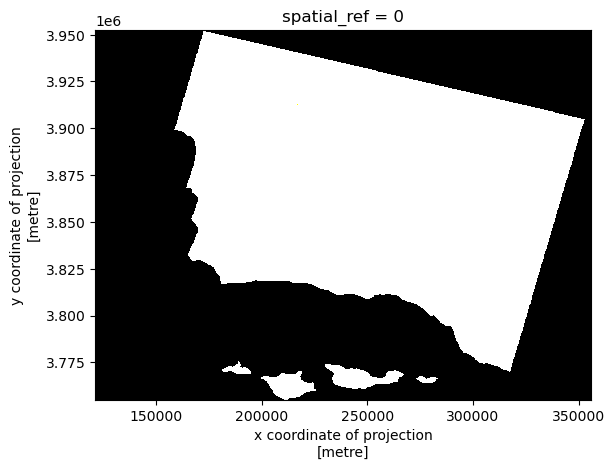

In [5]:
# Select the red, green, and blue variables, convert to array, and plot image
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

The issue here is the clouds: their RGB values are outliers and cause the other values to be squished when plotting. I now adjust the scale to deal with this issue using the parameter `robust = True`

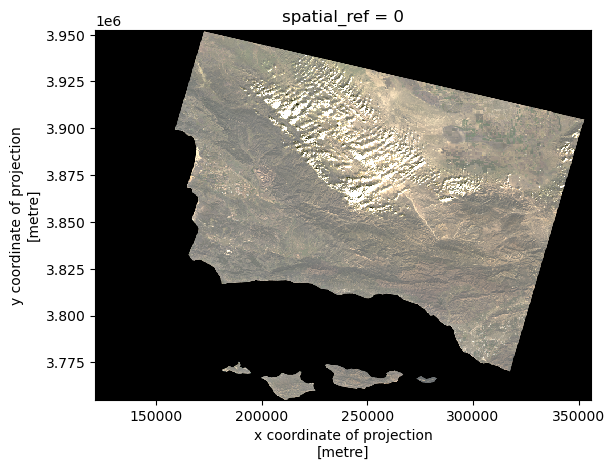

In [6]:
# Adjust the scale used for plotting the bands to get a true color image
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

By setting `robust = True` in `imshow()`, I adjust the display of the image to handle color scaling appropriately by ignoring the outlier RBG values caused by clouds. It fixed the contrast issue that's seen in the first image (causing it to appear black and white), and now I have a true color image from our Landsat data that can be interpreted (the second image).

### False color image

Create a false color image with the Landsat data:

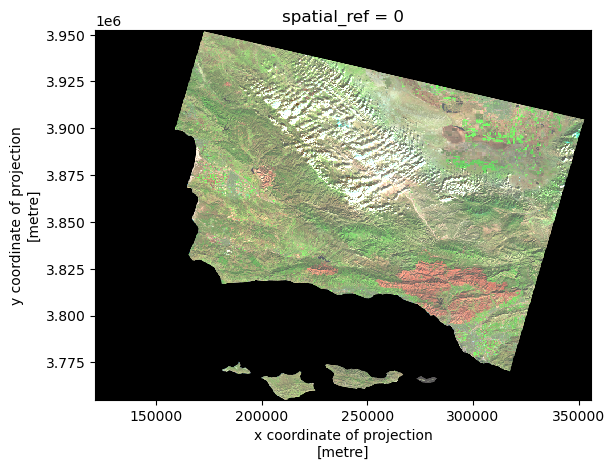

In [7]:
# Select the short-wave infrared, near-infrared, and red variables, convert to array, and plot
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

### Map

Now, I create a map showing the false color image together with the Thomas Fire perimeter to visualize the fire scars.

In [8]:
# First, match Thomas Fire and Landsat CRS
landsat = landsat.rio.reproject(thomas_boundary.crs)

# Check that reprojection worked
assert landsat.rio.crs == thomas_boundary.crs

ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [9]:
thomas_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
thomas_boundary

,year_,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,cause,c_method,objective,gis_acres,comments,complex_na,irwinid,fire_num,complex_id,decades,geometry
0,2017,CA,USF,VNC,THOMAS,00003583,2017-12-04,2018-01-12,9,7,1,281791.0,CONT_DATE based on Inciweb,None,None,None,None,2010,"MULTIPOLYGON (((-13316089.01600 4088553.04020,..."


In [11]:
landsat.rio.crs

ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

ValueError: aspect must be finite and positive 

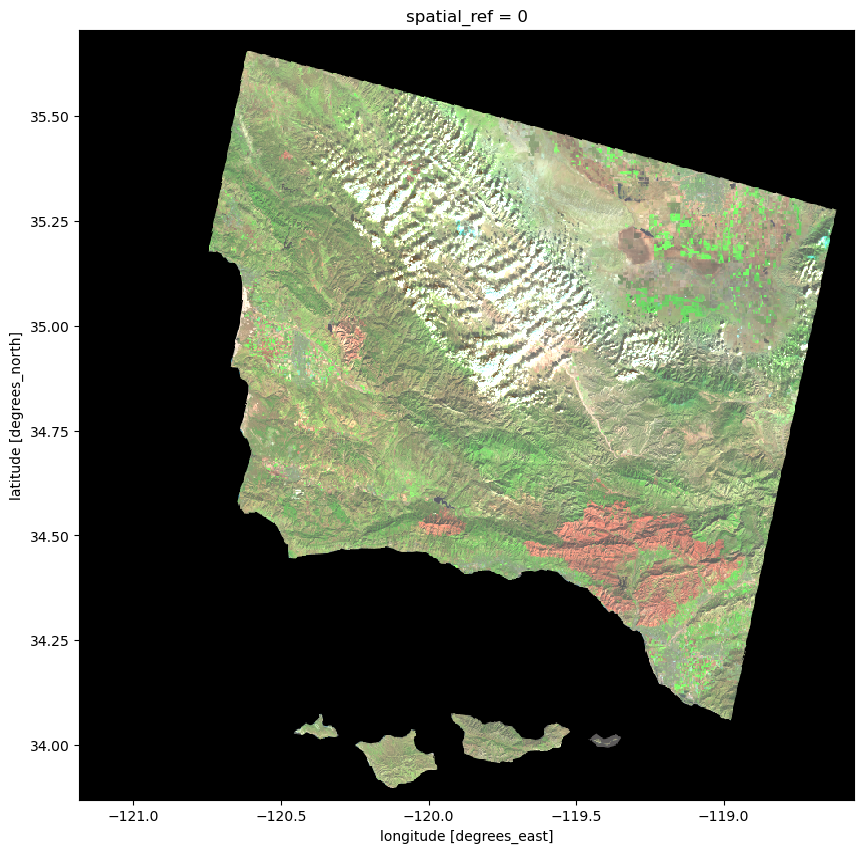

In [12]:
# Initialize plot
fig, ax = plt.subplots(figsize = (10, 10))  # Update figure size

# Remove axis for cleaner map
#ax.axis('off')

# Title for the plot
ax.set_title("2017 Thomas Fire (California) Burn Scar using False Color Imagery")

# Plot false color image
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True, ax=ax, zorder=1)

# Plot Thomas Fire perimeter
thomas_boundary.plot(ax=ax, 
                    edgecolor = 'purple',
                    color = 'none',
                    linewidth = 10,
                    zorder=2)

# Display the plot
plt.show()